# FLOPATN - Flow Pattern Prediction and Plotting Computer Code
-------------------

![alt text](images/flow-pattern-map.png)

Please Contact to Dr. Ovadia Shoham by os@utulsa.edu or Dr. Eduardo Pereyra for more info about `FLOPATN`.

In [1]:
import subprocess
from pathlib import Path
import numpy as np
%matplotlib ipympl
import seaborn as sns
import matplotlib.pyplot as plt
from buttons import *
from ipywidgets import interact
from IPython.display import HTML, display

FLOWPATEXE = "external/Flowpat.exe"

def create_transition_lines_input_file(ρ_L, ρ_G, μ_L, μ_G, σ, D, θ, k_s, interface, out_path):
    mode = 1
    with open(out_path / "Input.txt", "w") as f:
        f.write(f"{mode}          Mode 1-Transition Lines, 2-FlowPattern Prediction\n")
        f.write(f"{      ρ_L:<10.5g} Liquid Density [Kg/m^3]\n")
        f.write(f"{      μ_L:<10.5g} Liquid Viscosity [Pa s]\n")
        f.write(f"{        σ:<10.5g} Surface Tension [N/m]\n")
        f.write(f"{      ρ_G:<10.5g} Gas Density [Kg/m^3]\n")
        f.write(f"{      μ_G:<10.5g} Gas Viscosity [Pa s]\n")
        f.write(f"{        D:<10.5g} Pipe Diameter [m]\n")
        f.write(f"{        θ:<10.5g} Pipe inclination  Angle [deg]\n")
        f.write(f"{      k_s:<10.5g} Pipe Roughness [m]\n")
        f.write(f"{interface}          Interface 1-Smooth, 2-Wavy\n")

def create_flow_pattern_input_file(us_L, us_G, ρ_L, ρ_G, μ_L, μ_G, σ, D, θ, k_s, out_path):
    mode = 2
    with open(out_path / "Input.txt", "w") as f:
        f.write(f"{mode}          Mode 1-Transition Lines, 2-FlowPattern Prediction\n")
        f.write(f"{us_L:<10.5g} ")
        f.write(f"{us_G:<10.5g} ")
        f.write(f"{ ρ_L:<10.5g} ")
        f.write(f"{ μ_L:<10.5g} ")
        f.write(f"{ ρ_G:<10.5g} ")
        f.write(f"{ μ_G:<10.5g} ")
        f.write(f"{   σ:<10.5g} ")
        f.write(f"{   D:<10.5g} ")
        f.write(f"{   θ:<10.5g} ")
        f.write(f"{ k_s:<10.5g} ")

def create_out_path():
    out_path = Path("out")
    out_path.mkdir(exist_ok=True)
    return out_path

def run_flowpat(out_path):
    subprocess.call([FLOWPATEXE], cwd=out_path)
    return np.loadtxt(out_path / "Output.txt")

def calculate_transition_lines(ρ_L, ρ_G, μ_L, μ_G, σ, D, θ, k_s, interface):
    out_path = create_out_path()
    create_transition_lines_input_file(ρ_L, ρ_G, μ_L, μ_G, σ, D, θ, k_s, interface, out_path)
    return run_flowpat(out_path)

flow_pattern_name = {
    1: ("SS", "Stratified"),
    2: ("SW", "Stratified Wavy"),
    3: ("A",  "Annular"),
    4: ("DB", "Dispersed Bubble"),
    5: ("B", "Bubbly"),
    6: ("SL", "Slug"),
}
def calculate_flow_pattern(us_L, us_G, ρ_L, ρ_G, μ_L, μ_G, σ, D, θ, k_s):
    out_path = create_out_path()
    create_flow_pattern_input_file(us_L, us_G, ρ_L, ρ_G, μ_L, μ_G, σ, D, θ, k_s, out_path)
    results = run_flowpat(out_path)

    error_code = results[-1] if len(results) > 0 else -999
    
    if error_code > 0:
        return None

    flow_pattern_id = int(results[-2])
    return flow_pattern_name[flow_pattern_id]

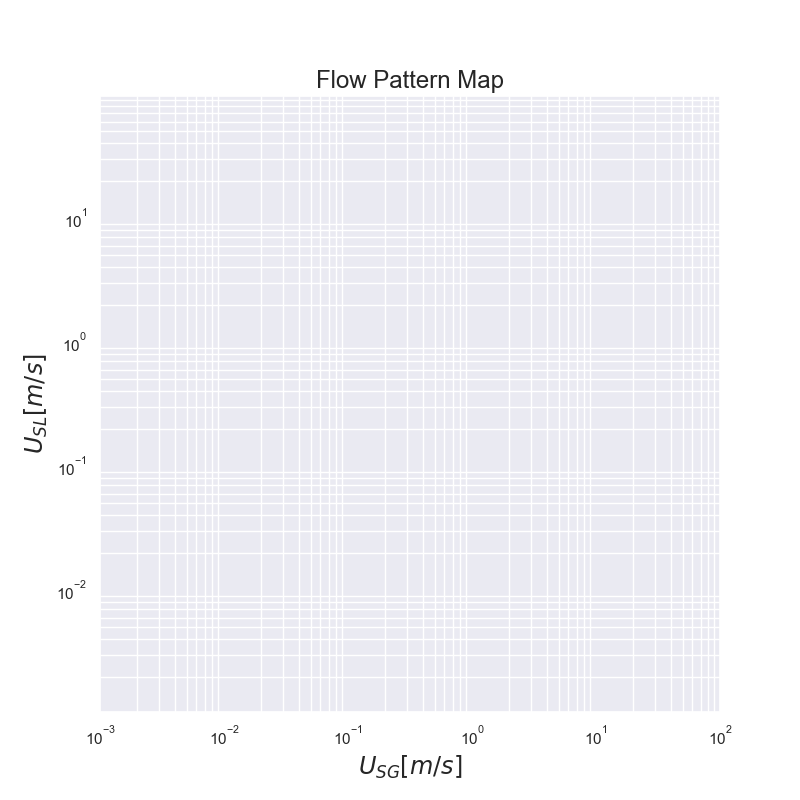

interactive(children=(FloatSlider(value=0.1, description='Gas Superficial Velocity [m/s]', layout=Layout(align…

In [2]:
display(HTML('''<style>
    .widget-label { min-width: 30ex !important; }
</style>'''))

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots()
fig.set_size_inches(8.0, 8.0)
ax.set_title('Flow Pattern Map', fontsize='x-large')

labels = ['Stratified', 'Annular', 'Wavy', 'Dispersed-Bubble', 'Bubble Flow', 'Flow pattern ID']
colors = ["m", "g", "b", "r", "y", "k"]
markers = ['.', '.', '.', '.', '.', 'o']

ax.grid(which='both')
ax.axis('equal')
ax.set_ylim(1e-3, 100)
ax.set_xlim(1e-3, 100)
ax.set_xlabel('$U_{SG} [m/s]$', fontsize='x-large')
ax.set_ylabel('$U_{SL} [m/s]$', fontsize='x-large')
ax.set(xscale="log", yscale="log")
plt.show()
text = None

def update_plot(x, y, ax, i):
    lines = ax.lines
    if lines and i < len(lines):
        line = ax.lines[i]
        line.set_xdata(x)
        line.set_ydata(y)
    else:
        ax.plot(x, y, markers[i], color=colors[i], label=labels[i])
        ax.legend()
  
@interact(
    us_G=us_G_button, us_L=us_L_button, 
    ρ_L=ρ_L_button, ρ_G=ρ_G_button, μ_L=μ_L_button, μ_G=μ_G_button,
    σ=σ_button, D=D_button, θ=θ_button,
    k_s=k_s_button, interface=interface_button,
)
def plot_transition_points(us_G, us_L, ρ_L, ρ_G, μ_L, μ_G, σ, D, θ, k_s, interface):
    transition = calculate_transition_lines(ρ_L, ρ_G, μ_L, μ_G, σ, D, θ, k_s, interface)
    flow_pattern = calculate_flow_pattern(us_L, us_G, ρ_L, ρ_G, μ_L, μ_G, σ, D, θ, k_s)
    
    n_transitions = 5
    for i in range(n_transitions):
        x = transition[:, 2 * i    ]
        y = transition[:, 2 * i + 1]
        update_plot(x, y, ax, i)

    global text
    if text:
        text.remove()
    if flow_pattern is None:
        update_plot([1e-3,], [1e-3,], ax, n_transitions)
    else:
        update_plot([us_G,], [us_L,], ax, n_transitions)
        short = flow_pattern[0]
        full = flow_pattern[1]
        text = ax.text(us_G, us_L, f" {short} - {full}", fontsize=18)
    
    fig.canvas.draw()

In [3]:
calculate_flow_pattern(
    us_L=0.070,
    us_G=1.0,
    ρ_L=997.9,
    ρ_G=3,
    μ_L=0.005,
    μ_G=0.00002,
    σ=0.07,
    D=0.1,
    θ=0.0,
    k_s=1e-5
)

('SS', 'Stratified')